In [2]:
from functools import partial
from pathlib import Path
from typing import cast

import gsw
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import numpy as np
import xarray as xr
from scipy.optimize import brentq as find_root

In [3]:
SIGMA_LAYER = 25.8  # kg/m^3; potential density of isopycnal surface to find the depth of
MLD_THRESHOLD = 0.1  # kg/m^3; threshold for mixed layer depth calculation

In [4]:
DATA_DIRECTORY = Path("../data")
CE09_OSPM_FILE = DATA_DIRECTORY / "ce09ospm_gridded_profiles.nc"

ce09 = xr.open_dataset(CE09_OSPM_FILE)
ce09 = ce09.squeeze().load()
ce09 = ce09.swap_dims({"pressure": "depth"})
# backfill surface data for identifying surface sigma_0, but limit to 5 m depth (10 data points at 0.5 m intervals)
ce09_bfill = ce09.bfill("depth", limit=10)
ce09["threshold_sigma_0"] = ce09_bfill["potential_density"].isel(depth=0) + MLD_THRESHOLD
ce09["salinity_absolute"] = gsw.SA_from_SP(
    ce09["salinity"],
    ce09["pressure"],
    ce09["longitude"],
    ce09["latitude"],
)
ce09["conservative_temperature"] = gsw.CT_from_t(
    ce09["salinity_absolute"],
    ce09["temperature"],
    ce09["pressure"],
)
ce09["spice"] = gsw.spiciness0(ce09["salinity_absolute"], ce09["conservative_temperature"])
ce09["alpha"] = gsw.alpha(ce09["salinity_absolute"], ce09["conservative_temperature"], ce09["pressure"])
ce09["beta"] = gsw.beta(ce09["salinity_absolute"], ce09["conservative_temperature"], ce09["pressure"])
ce09["grav"] = gsw.grav(ce09["latitude"], ce09["pressure"])

In [5]:
# swap negative signs when calculating N^2 components since depth is positive downward in dataset
ce09["N_squared_Theta"] = (
    -ce09.differentiate("depth", edge_order=2)["conservative_temperature"] * ce09["alpha"] * ce09["grav"]
)
ce09["N_squared_SA"] = ce09.differentiate("depth", edge_order=2)["salinity_absolute"] * ce09["beta"] * ce09["grav"]
ce09["N_squared_from_Theta_SA"] = ce09["N_squared_Theta"] + ce09["N_squared_SA"]

In [6]:
def calculate_mld(depth: np.ndarray, z: np.ndarray, sigma_0: np.ndarray, surface_sigma_0: float) -> float:
    """Calculate mixed layer depth for a single time step.

    Args:
        depth (np.ndarray): Array of depths at which to calculate the mixed layer depth.
        z (np.ndarray): Array of depths corresponding to sigma_0.
        sigma_0 (np.ndarray): Array of sigma_0 values.
        surface_sigma_0 (float): Surface sigma_0 value.

    Returns:
        float: Mixed layer depth.

    """
    mld = np.interp(depth, z, sigma_0, left=np.nan, right=np.nan) - surface_sigma_0
    return float(mld)


mld = np.full(ce09["time"].size, np.nan)
sigma_layer_depth = np.full(ce09["time"].size, np.nan)

for i, (sigma_0, surface_sigma_0) in enumerate(
    zip(
        ce09["potential_density"].isel(depth=slice(None)).to_numpy().T,
        ce09["threshold_sigma_0"].to_numpy(),
        strict=True,
    ),
):
    z = ce09["depth"].to_numpy()[~np.isnan(sigma_0)]
    sigma_0_filtered = sigma_0[~np.isnan(sigma_0)]
    try:
        mld[i] = find_root(
            partial(
                calculate_mld,
                z=z,
                sigma_0=sigma_0_filtered,
                surface_sigma_0=surface_sigma_0,
            ),
            np.min(z),
            np.max(z),
        )
    except ValueError:
        mld[i] = np.nan
    try:
        sigma_layer_depth[i] = find_root(
            partial(
                calculate_mld,
                z=z,
                sigma_0=sigma_0_filtered,
                surface_sigma_0=SIGMA_LAYER,
            ),
            np.min(z),
            np.max(z),
        )
    except ValueError:
        sigma_layer_depth[i] = np.nan

sigma_at_mld = ce09["potential_density"].interp(depth=xr.DataArray(mld, dims="time"))

c:\Users\asche\Desktop\po_code\ocean-tunnels-nccs\.venv\Lib\site-packages\xarray\core\missing.py:588: RuntimeWarning: All-NaN axis encountered
  minval = np.nanmin(new_x_loaded)
c:\Users\asche\Desktop\po_code\ocean-tunnels-nccs\.venv\Lib\site-packages\xarray\core\missing.py:589: RuntimeWarning: All-NaN axis encountered
  maxval = np.nanmax(new_x_loaded)


In [7]:
ce09

<xarray.Dataset> Size: 298MB
Dimensions:                   (depth: 961, time: 3876)
Coordinates:
  * depth                     (depth) float32 4kB 29.75 30.25 ... 504.7 505.2
  * time                      (time) datetime64[ns] 31kB 2014-10-08T12:00:00 ...
    latitude                  float32 4B 46.85
    longitude                 float32 4B 235.0
    pressure                  (depth) float32 4kB 30.0 30.5 31.0 ... 509.5 510.0
Data variables: (12/14)
    temperature               (depth, time) float32 15MB nan nan nan ... nan nan
    salinity                  (depth, time) float32 15MB nan nan nan ... nan nan
    potential_density         (depth, time) float32 15MB nan nan nan ... nan nan
    dissolved_oxygen          (depth, time) float32 15MB nan nan nan ... nan nan
    threshold_sigma_0         (time) float32 16kB 24.69 24.85 ... 24.96 24.97
    salinity_absolute         (depth, time) float64 30MB nan nan nan ... nan nan
    ...                        ...
    alpha                     (depth, time) float64 30MB nan nan nan ... nan nan
    beta                      (depth, time) float64 30MB nan nan nan ... nan nan
    grav                      (depth) float64 8kB 9.808 9.808 ... 9.809 9.809
    N_squared_Theta           (depth, time) float64 30MB nan nan nan ... nan nan
    N_squared_SA              (depth, time) float64 30MB nan nan nan ... nan nan
    N_squared_from_Theta_SA   (depth, time) float64 30MB nan nan nan ... nan nan
Attributes: (12/67)
    title:                           CE09OSPM CTD and Dissolved Oxygen Data: ...
    summary:                         This file contains profiler data collect...
    date_created:                    2025-06-09T17:23:37
    history:                         Created: 2025-06-09T17:23:37
    keywords:                        OSU, NSF, OOI, CE09OSPM, endurance array...
    keyword_vocabulary:              GCMD
    ...                              ...
    keywords_vocabulary:             GCMD Science Keywords
    date_modified:                   2025-06-09T00:00:00Z
    date_issued:                     2025-06-09T00:00:00Z
    geospatial_vertical_units:       dbar
    geospatial_vertical_resolution:  0.5 dbar
    geospatial_vertical_positive:    down

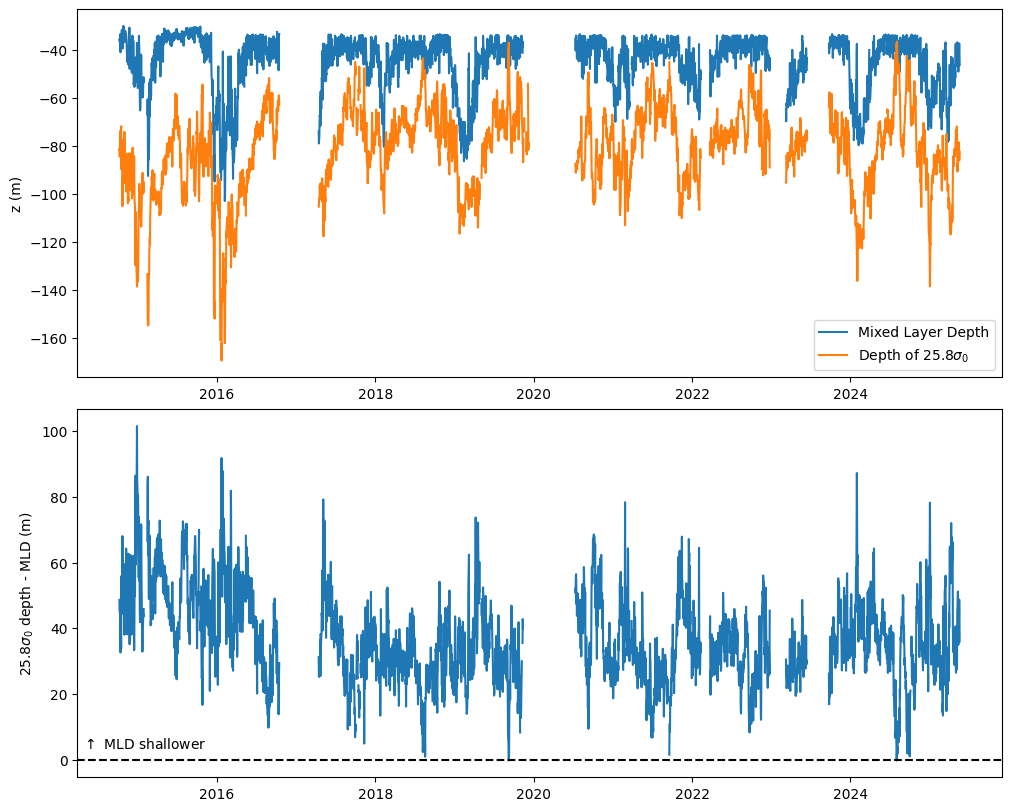

In [8]:
fig, axs = plt.subplots(2, 1, figsize=(10, 8), layout="constrained")
ax1: plt.Axes = axs[0]
ax2: plt.Axes = axs[1]

ax1.plot(ce09["time"], -mld, label="Mixed Layer Depth")
ax1.plot(ce09["time"], -sigma_layer_depth, label=f"Depth of {SIGMA_LAYER}$\\sigma_0$")
ax1.set_ylabel("z (m)")
ax1.legend()

ax2.plot(ce09["time"], sigma_layer_depth - mld)
ax2.set_ylabel(f"{SIGMA_LAYER}$\\sigma_0$ depth - MLD (m)")
ax2.annotate(
    "$\\uparrow$ MLD shallower",
    xy=(0.005, 0.08),
    xycoords="axes fraction",
    ha="left",
)
ax2.axhline(0, color="k", linestyle="--")

plt.savefig("../misc/wa_profiler_mld_sigma_layer_depth.png", dpi=300)

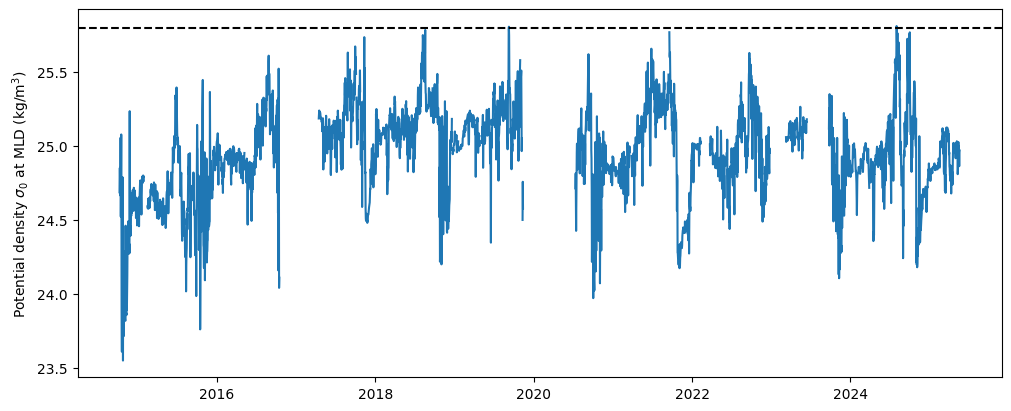

In [9]:
fig, ax = plt.subplots(1, 1, figsize=(10, 4), layout="constrained")

ax.plot(ce09["time"], sigma_at_mld)
ax.set_ylabel("Potential density $\\sigma_0$ at MLD (kg/m$^3$)")
ax.axhline(SIGMA_LAYER, color="k", linestyle="--")
plt.savefig("../misc/wa_profiler_sigma_at_mld.png", dpi=300)

## Time series along 25.8 and 26.0

In [10]:
SIGMA_LAYERS = [25.8, 26.0]

In [11]:
def calculate_mld(depth: np.ndarray, z: np.ndarray, sigma_0: np.ndarray, surface_sigma_0: float) -> float:
    """Calculate mixed layer depth for a single time step.

    Args:
        depth (np.ndarray): Array of depths at which to calculate the mixed layer depth.
        z (np.ndarray): Array of depths corresponding to sigma_0.
        sigma_0 (np.ndarray): Array of sigma_0 values.
        surface_sigma_0 (float): Surface sigma_0 value.

    Returns:
        float: Mixed layer depth.

    """
    mld = np.interp(depth, z, sigma_0, left=np.nan, right=np.nan) - surface_sigma_0
    return float(mld)


sigma_layers_depth_array = np.full((len(SIGMA_LAYERS), ce09["time"].size), np.nan)

for i, sigma_0 in enumerate(
    ce09["potential_density"].isel(depth=slice(None)).to_numpy().T,
):
    z = ce09["depth"].to_numpy()[~np.isnan(sigma_0)]
    sigma_0_filtered = sigma_0[~np.isnan(sigma_0)]
    for j, sigma_layer in enumerate(SIGMA_LAYERS):
        try:
            sigma_layers_depth_array[j, i] = find_root(
                partial(
                    calculate_mld,
                    z=z,
                    sigma_0=sigma_0_filtered,
                    surface_sigma_0=sigma_layer,
                ),
                np.min(z),
                np.max(z),
            )
        except ValueError:
            sigma_layers_depth_array[j, i] = np.nan

sigma_layers_depth_da = xr.DataArray(
    sigma_layers_depth_array,
    dims=["sigma_layer", "time"],
    coords={"sigma_layer": SIGMA_LAYERS, "time": ce09["time"]},
)

In [17]:
oxy_interp = ce09["dissolved_oxygen"].interp(depth=sigma_layers_depth_da)
temp_interp = ce09["conservative_temperature"].interp(depth=sigma_layers_depth_da)
sal_interp = ce09["salinity"].interp(depth=sigma_layers_depth_da)
spice_interp = ce09["spice"].interp(depth=sigma_layers_depth_da)
n_squared_theta_interp = ce09["N_squared_Theta"].interp(depth=sigma_layers_depth_da)
n_squared_sa_interp = ce09["N_squared_SA"].interp(depth=sigma_layers_depth_da)
n_squared_from_theta_sa_interp = ce09["N_squared_from_Theta_SA"].interp(depth=sigma_layers_depth_da)
# stratification control index as in https://journals.ametsoc.org/view/journals/phoc/52/8/JPO-D-21-0295.1.xml
sci = (n_squared_theta_interp - n_squared_sa_interp) / (n_squared_theta_interp + n_squared_sa_interp)

c:\Users\asche\Desktop\po_code\ocean-tunnels-nccs\.venv\Lib\site-packages\xarray\core\missing.py:588: RuntimeWarning: All-NaN slice encountered
  minval = np.nanmin(new_x_loaded)
c:\Users\asche\Desktop\po_code\ocean-tunnels-nccs\.venv\Lib\site-packages\xarray\core\missing.py:589: RuntimeWarning: All-NaN slice encountered
  maxval = np.nanmax(new_x_loaded)


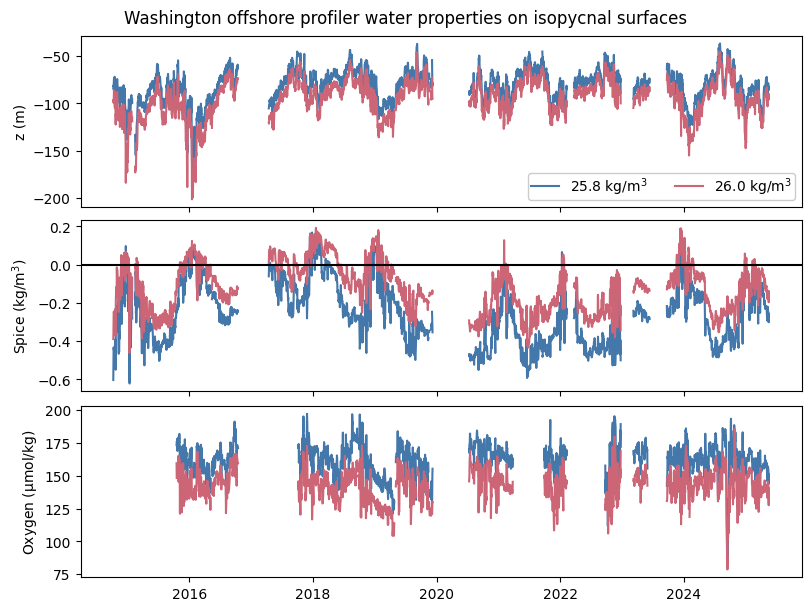

In [ ]:
fig, axs = plt.subplots(3, 1, figsize=(8, 6), layout="constrained", sharex=True)
ax0 = cast("plt.Axes", axs[0])
ax1 = cast("plt.Axes", axs[1])
ax2 = cast("plt.Axes", axs[2])

ax0.plot(ce09["time"], -sigma_layers_depth_da.sel(sigma_layer=25.8), label="25.8 $\\mathsf{kg/m^3}$", c="#4477AA")
ax0.plot(ce09["time"], -sigma_layers_depth_da.sel(sigma_layer=26.0), label="26.0 $\\mathsf{kg/m^3}$", c="#CC6677")
ax1.plot(ce09["time"], spice_interp.sel(sigma_layer=25.8), c="#4477AA")
ax1.plot(ce09["time"], spice_interp.sel(sigma_layer=26.0), c="#CC6677")
ax2.plot(ce09["time"], oxy_interp.sel(sigma_layer=25.8), c="#4477AA")
ax2.plot(ce09["time"], oxy_interp.sel(sigma_layer=26.0), c="#CC6677")

ax0.set_ylabel("z (m)")
ax1.set_ylabel("Spice ($\\mathsf{kg/m^3}$)")
ax2.set_ylabel("Oxygen ($\\mathsf{\\mu mol/kg}$)")

ax0.legend(framealpha=1, ncols=2, borderpad=0.2)
ax1.axhline(0, color="k", linestyle="-")

fig.suptitle("Washington offshore profiler water properties on isopycnal surfaces")

plt.savefig("../misc/wa_offshore_profiler_isopycnal_properties_timeseries.png", dpi=300)

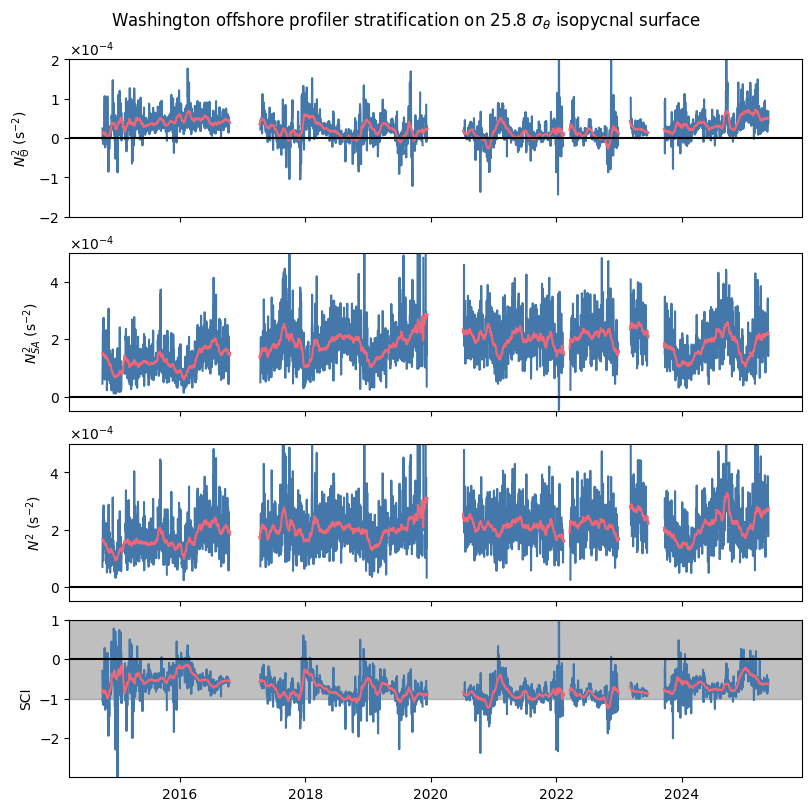

In [32]:
fig, axs = plt.subplots(4, 1, figsize=(8, 8), layout="constrained", sharex=True)
ax0 = cast("plt.Axes", axs[0])
ax1 = cast("plt.Axes", axs[1])
ax2 = cast("plt.Axes", axs[2])
ax3 = cast("plt.Axes", axs[3])

ax0.plot(ce09["time"], n_squared_theta_interp.sel(sigma_layer=25.8), c="#4477AA")
ax0.plot(
    ce09["time"],
    n_squared_theta_interp.sel(sigma_layer=25.8).rolling(time=30, center=True, min_periods=10).mean(window="hann"),
    c="#EE6677",
)
ax1.plot(ce09["time"], n_squared_sa_interp.sel(sigma_layer=25.8), c="#4477AA")
ax1.plot(
    ce09["time"],
    n_squared_sa_interp.sel(sigma_layer=25.8).rolling(time=30, center=True, min_periods=10).mean(window="hann"),
    c="#EE6677",
)
ax2.plot(ce09["time"], n_squared_from_theta_sa_interp.sel(sigma_layer=25.8), c="#4477AA")
ax2.plot(
    ce09["time"],
    n_squared_from_theta_sa_interp.sel(sigma_layer=25.8)
    .rolling(time=30, center=True, min_periods=10)
    .mean(window="hann"),
    c="#EE6677",
)
ax3.plot(ce09["time"], sci.sel(sigma_layer=25.8), c="#4477AA")
ax3.plot(
    ce09["time"],
    sci.sel(sigma_layer=25.8).rolling(time=30, center=True, min_periods=10).mean(window="hann"),
    c="#EE6677",
)
xlim = ax0.get_xlim()

ax0.set_ylabel("$N^2_\\Theta$ ($\\mathsf{s^{-2}}$)")
ax1.set_ylabel("$N^2_{SA}$ ($\\mathsf{s^{-2}}$)")
ax2.set_ylabel("$N^2$ ($\\mathsf{s^{-2}}$)")
ax3.set_ylabel("SCI")

ax0.axhline(0, color="k", linestyle="-")
ax1.axhline(0, color="k", linestyle="-")
ax2.axhline(0, color="k", linestyle="-")
ax3.axhline(0, color="k", linestyle="-")

ax3.fill_between(
    xlim,
    -1,
    1,
    color="gray",
    alpha=0.5,
)

ax0.set_ylim(-2e-4, 2e-4)
ax1.set_ylim(-0.5e-4, 5e-4)
ax2.set_ylim(-0.5e-4, 5e-4)
ax3.set_ylim(-3, 1)
ax3.set_yticks([-2, -1, 0, 1])

ax0.set_xlim(xlim)

formatter = mticker.ScalarFormatter(useMathText=True)
formatter.set_scientific(True)
formatter.set_powerlimits((0, 0))  # forces all numbers into scientific
ax0.yaxis.set_major_formatter(formatter)
ax1.yaxis.set_major_formatter(formatter)
ax2.yaxis.set_major_formatter(formatter)

fig.suptitle("Washington offshore profiler stratification on 25.8 $\\sigma_{\\theta}$ isopycnal surface")

plt.savefig("../misc/wa_offshore_profiler_25.8_isopycnal_n_squared.png", dpi=300)

In [25]:
xlim

(np.float64(0.0), np.float64(1.0))

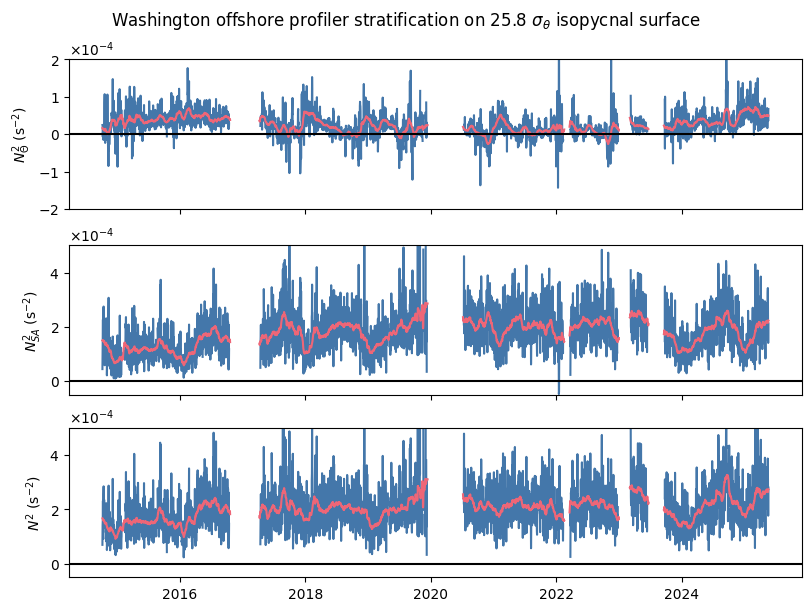

In [16]:
fig, axs = plt.subplots(3, 1, figsize=(8, 6), layout="constrained", sharex=True)
ax0 = cast("plt.Axes", axs[0])
ax1 = cast("plt.Axes", axs[1])
ax2 = cast("plt.Axes", axs[2])

ax0.plot(ce09["time"], n_squared_theta_interp.sel(sigma_layer=25.8), c="#4477AA")
ax0.plot(
    ce09["time"],
    n_squared_theta_interp.sel(sigma_layer=25.8).rolling(time=30, center=True, min_periods=10).mean(window="hann"),
    c="#EE6677",
)
ax1.plot(ce09["time"], n_squared_sa_interp.sel(sigma_layer=25.8), c="#4477AA")
ax1.plot(
    ce09["time"],
    n_squared_sa_interp.sel(sigma_layer=25.8).rolling(time=30, center=True, min_periods=10).mean(window="hann"),
    c="#EE6677",
)
ax2.plot(ce09["time"], n_squared_from_theta_sa_interp.sel(sigma_layer=25.8), c="#4477AA")
ax2.plot(
    ce09["time"],
    n_squared_from_theta_sa_interp.sel(sigma_layer=25.8)
    .rolling(time=30, center=True, min_periods=10)
    .mean(window="hann"),
    c="#EE6677",
)

ax0.set_ylabel("$N^2_\\Theta$ ($\\mathsf{s^{-2}}$)")
ax1.set_ylabel("$N^2_{SA}$ ($\\mathsf{s^{-2}}$)")
ax2.set_ylabel("$N^2$ ($\\mathsf{s^{-2}}$)")

ax0.axhline(0, color="k", linestyle="-")
ax1.axhline(0, color="k", linestyle="-")
ax2.axhline(0, color="k", linestyle="-")

ax0.set_ylim(-2e-4, 2e-4)
ax1.set_ylim(-0.5e-4, 5e-4)
ax2.set_ylim(-0.5e-4, 5e-4)

formatter = mticker.ScalarFormatter(useMathText=True)
formatter.set_scientific(True)
formatter.set_powerlimits((0, 0))  # forces all numbers into scientific
ax0.yaxis.set_major_formatter(formatter)
ax1.yaxis.set_major_formatter(formatter)
ax2.yaxis.set_major_formatter(formatter)

fig.suptitle("Washington offshore profiler stratification on 25.8 $\\sigma_{\\theta}$ isopycnal surface")

plt.savefig("../misc/wa_offshore_profiler_25.8_isopycnal_n_squared.png", dpi=300)